In [1]:
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2022-04-19 19:37:28.373942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 19:37:28.373977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
latent_dim = 100
number_of_classes = 10

In [3]:
def make_generator_base_model(latent_dim):
    noise = keras.layers.Input(shape=[latent_dim])

    hidden = keras.layers.Reshape((1, 1, latent_dim), name="reshape")(noise)

    hidden = keras.layers.Conv2DTranspose(512, 4, 1, 'valid')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2DTranspose(256, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2DTranspose(128, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2DTranspose(3, 3, 2, 'same')(hidden)
    out = keras.layers.Activation("tanh")(hidden)

    return keras.models.Model(noise, out, name="generator")

In [4]:
def make_label_conditioning_generator(latent_dim, number_of_classes, base_generator):
    noise = keras.layers.Input(shape=[latent_dim], name="noise")
    label = keras.layers.Input(shape=(1, ), name="label")
    label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
    label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)    
    gen_input = keras.layers.Multiply(name="multiply")([noise, label_embedding])

    base_out = base_generator(gen_input)

    return keras.models.Model([noise, label], base_out)

In [5]:
generator_base = make_generator_base_model(latent_dim)

2022-04-19 19:37:30.635663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-19 19:37:30.635701: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-19 19:37:30.635727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-04-19 19:37:30.635972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
label_conditioning_generator = make_label_conditioning_generator(latent_dim, number_of_classes, generator_base)

In [7]:
label_conditioning_generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        label[0][0]                      
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
______________________________________________________________________________________________

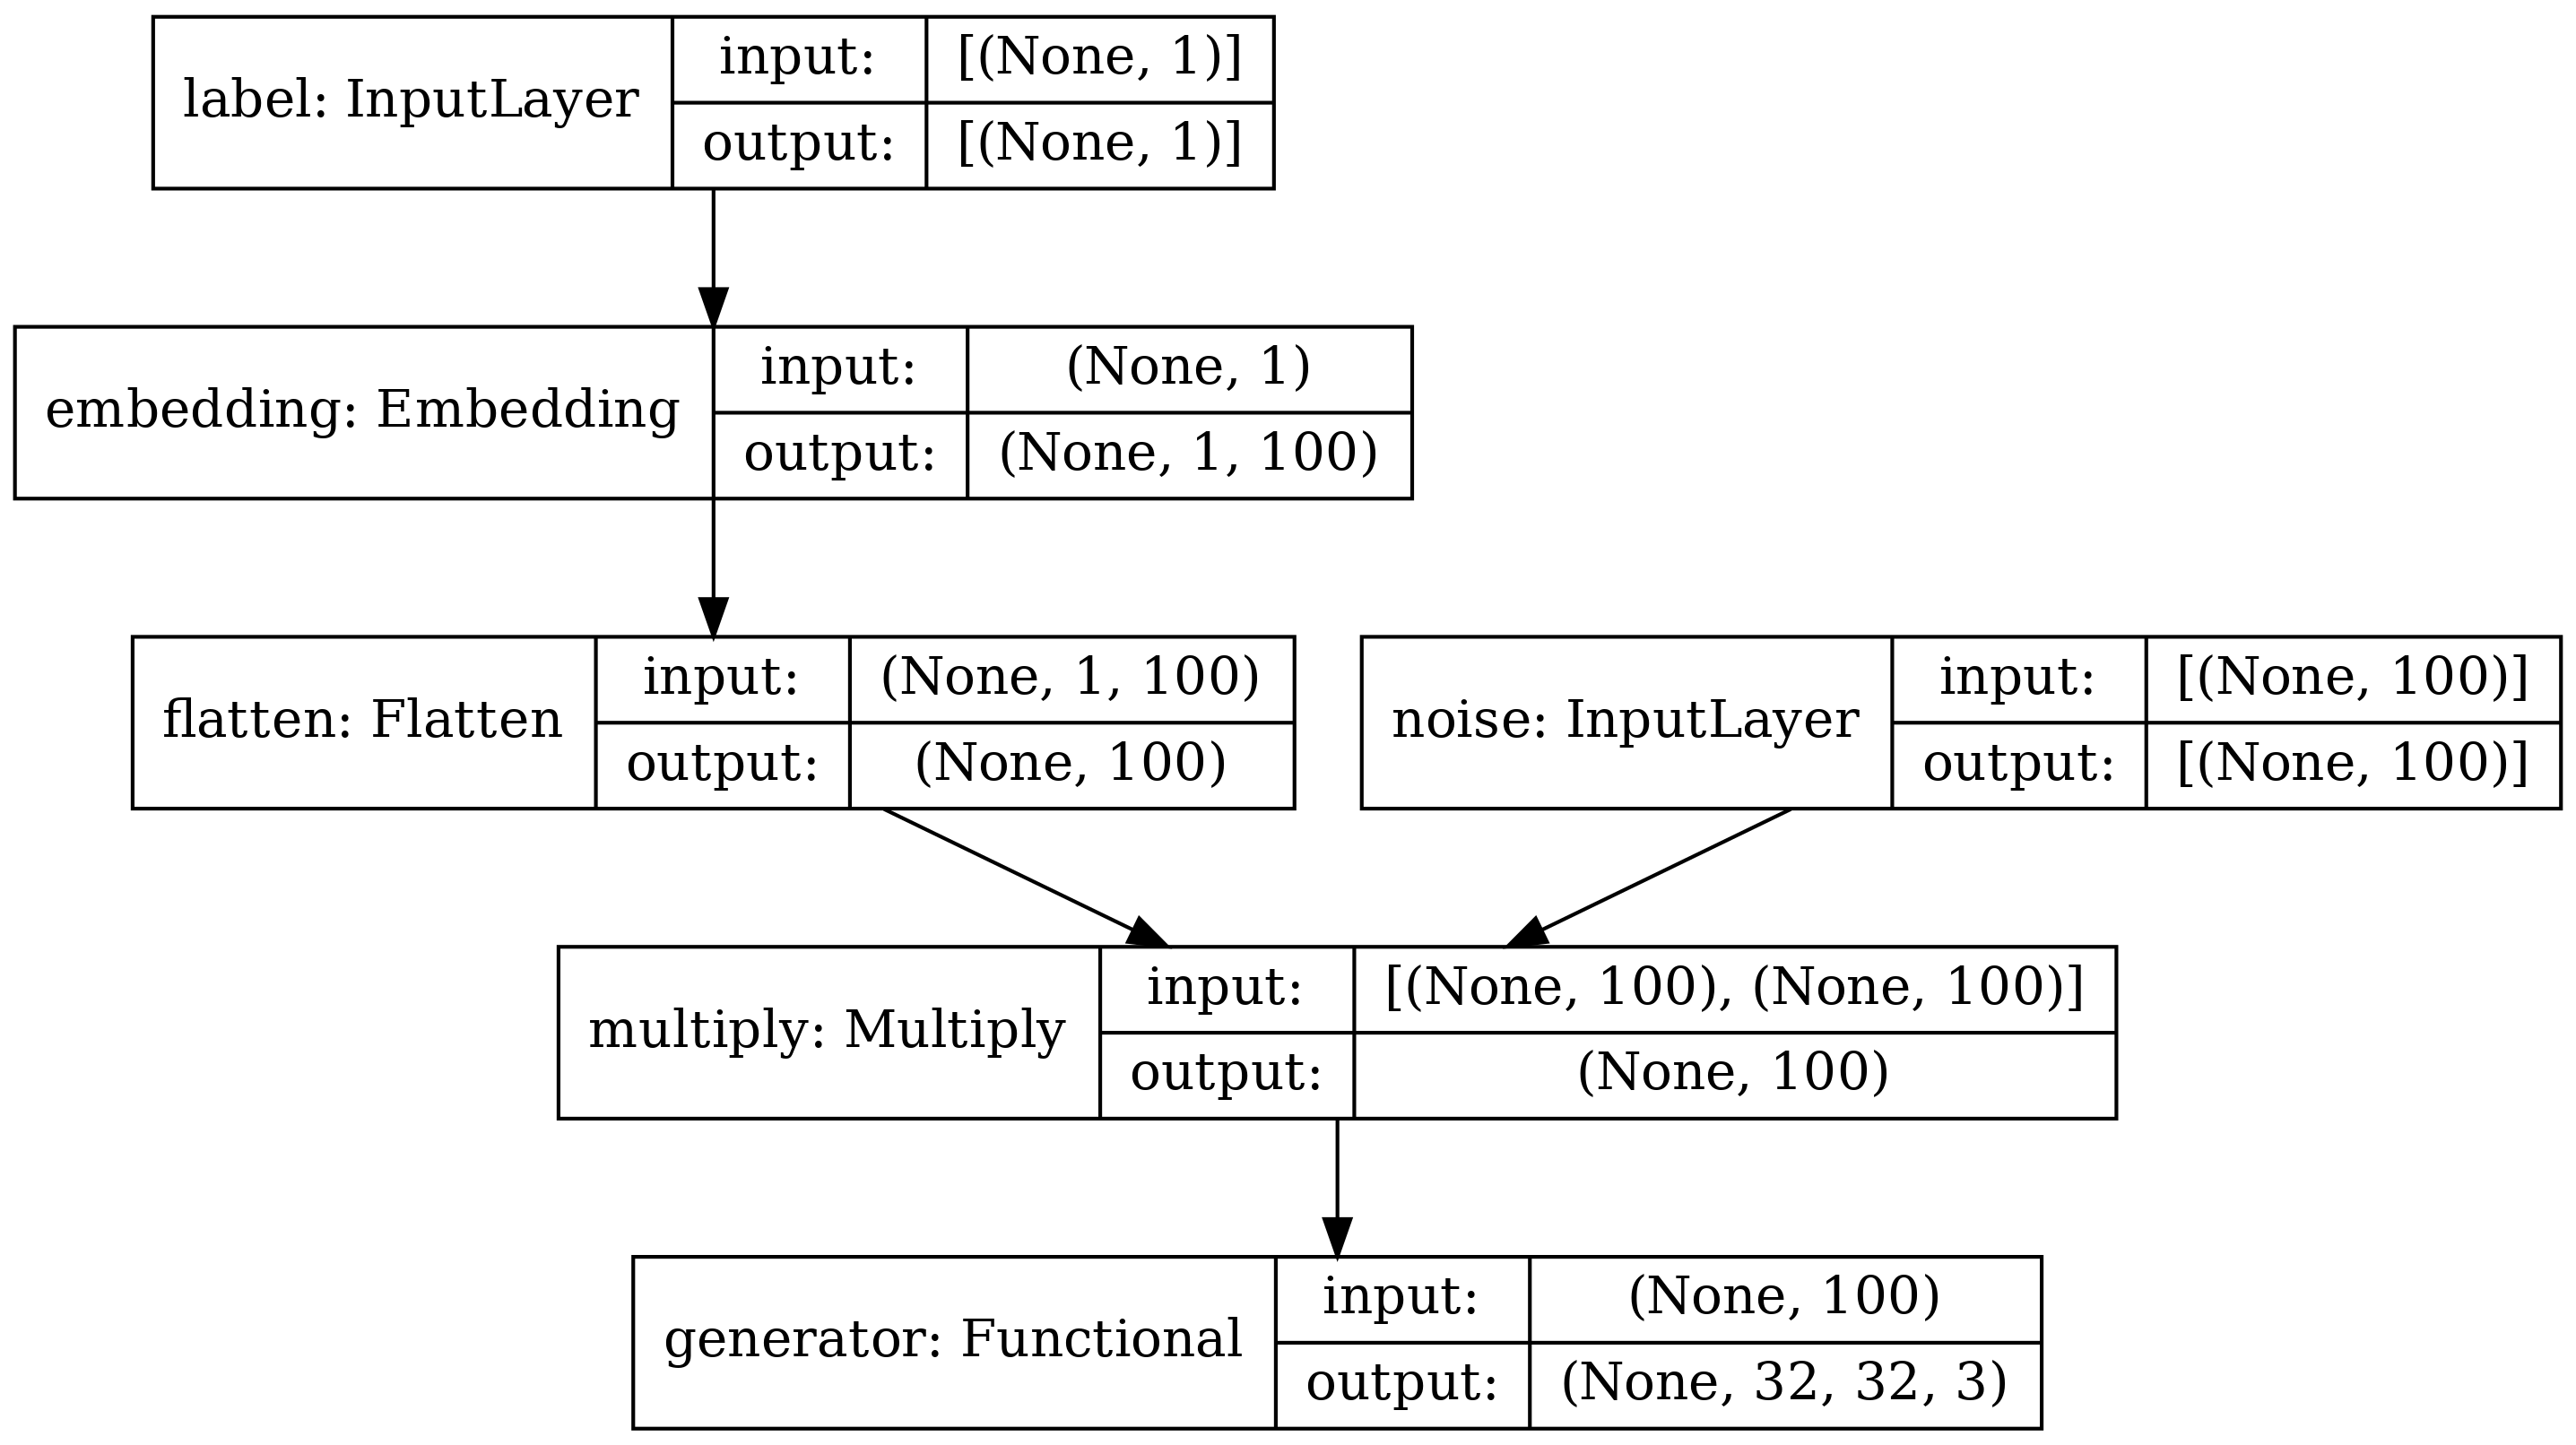

In [8]:
keras.utils.plot_model(label_conditioning_generator, dpi=300, show_shapes=True)

In [9]:
def make_feature_extractor_model(latent_dim):
    image = keras.layers.Input(shape=(32, 32, 3))

    hidden = keras.layers.Conv2D(128, 3, 2, 'same')(image)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2D(256, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2D(512, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)

    hidden = keras.layers.Conv2D(latent_dim, 4, 1, 'valid', name="convka")(hidden)
    hidden = keras.layers.ReLU()(hidden)
    features = keras.layers.Flatten()(hidden)

    return keras.models.Model(image, features, name="featureExt")

In [10]:
def make_label_conditioning_discriminator(latent_dim, number_of_classes, feture_extractor):
    image = keras.layers.Input(shape=(32, 32, 3), name="image")

    label = keras.layers.Input(shape=(1, ), name="label")

    features = feature_extractor(image)

    label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
    label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)
    embedded_space = keras.layers.Multiply(name="multiply")([features, label_embedding]) 

    hidden = keras.layers.Dropout(0.3, name="dropout")(embedded_space)
    out = keras.layers.Dense(1, name="output")(hidden)

    return keras.models.Model([image, label], out)

In [11]:
feature_extractor = make_feature_extractor_model(latent_dim)

In [12]:
label_conditioning_discriminator = make_label_conditioning_discriminator(latent_dim, number_of_classes, feature_extractor)

In [13]:
label_conditioning_discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        label[0][0]                      
__________________________________________________________________________________________________
featureExt (Functional)         (None, 100)          2301796     image[0][0]                      
____________________________________________________________________________________________

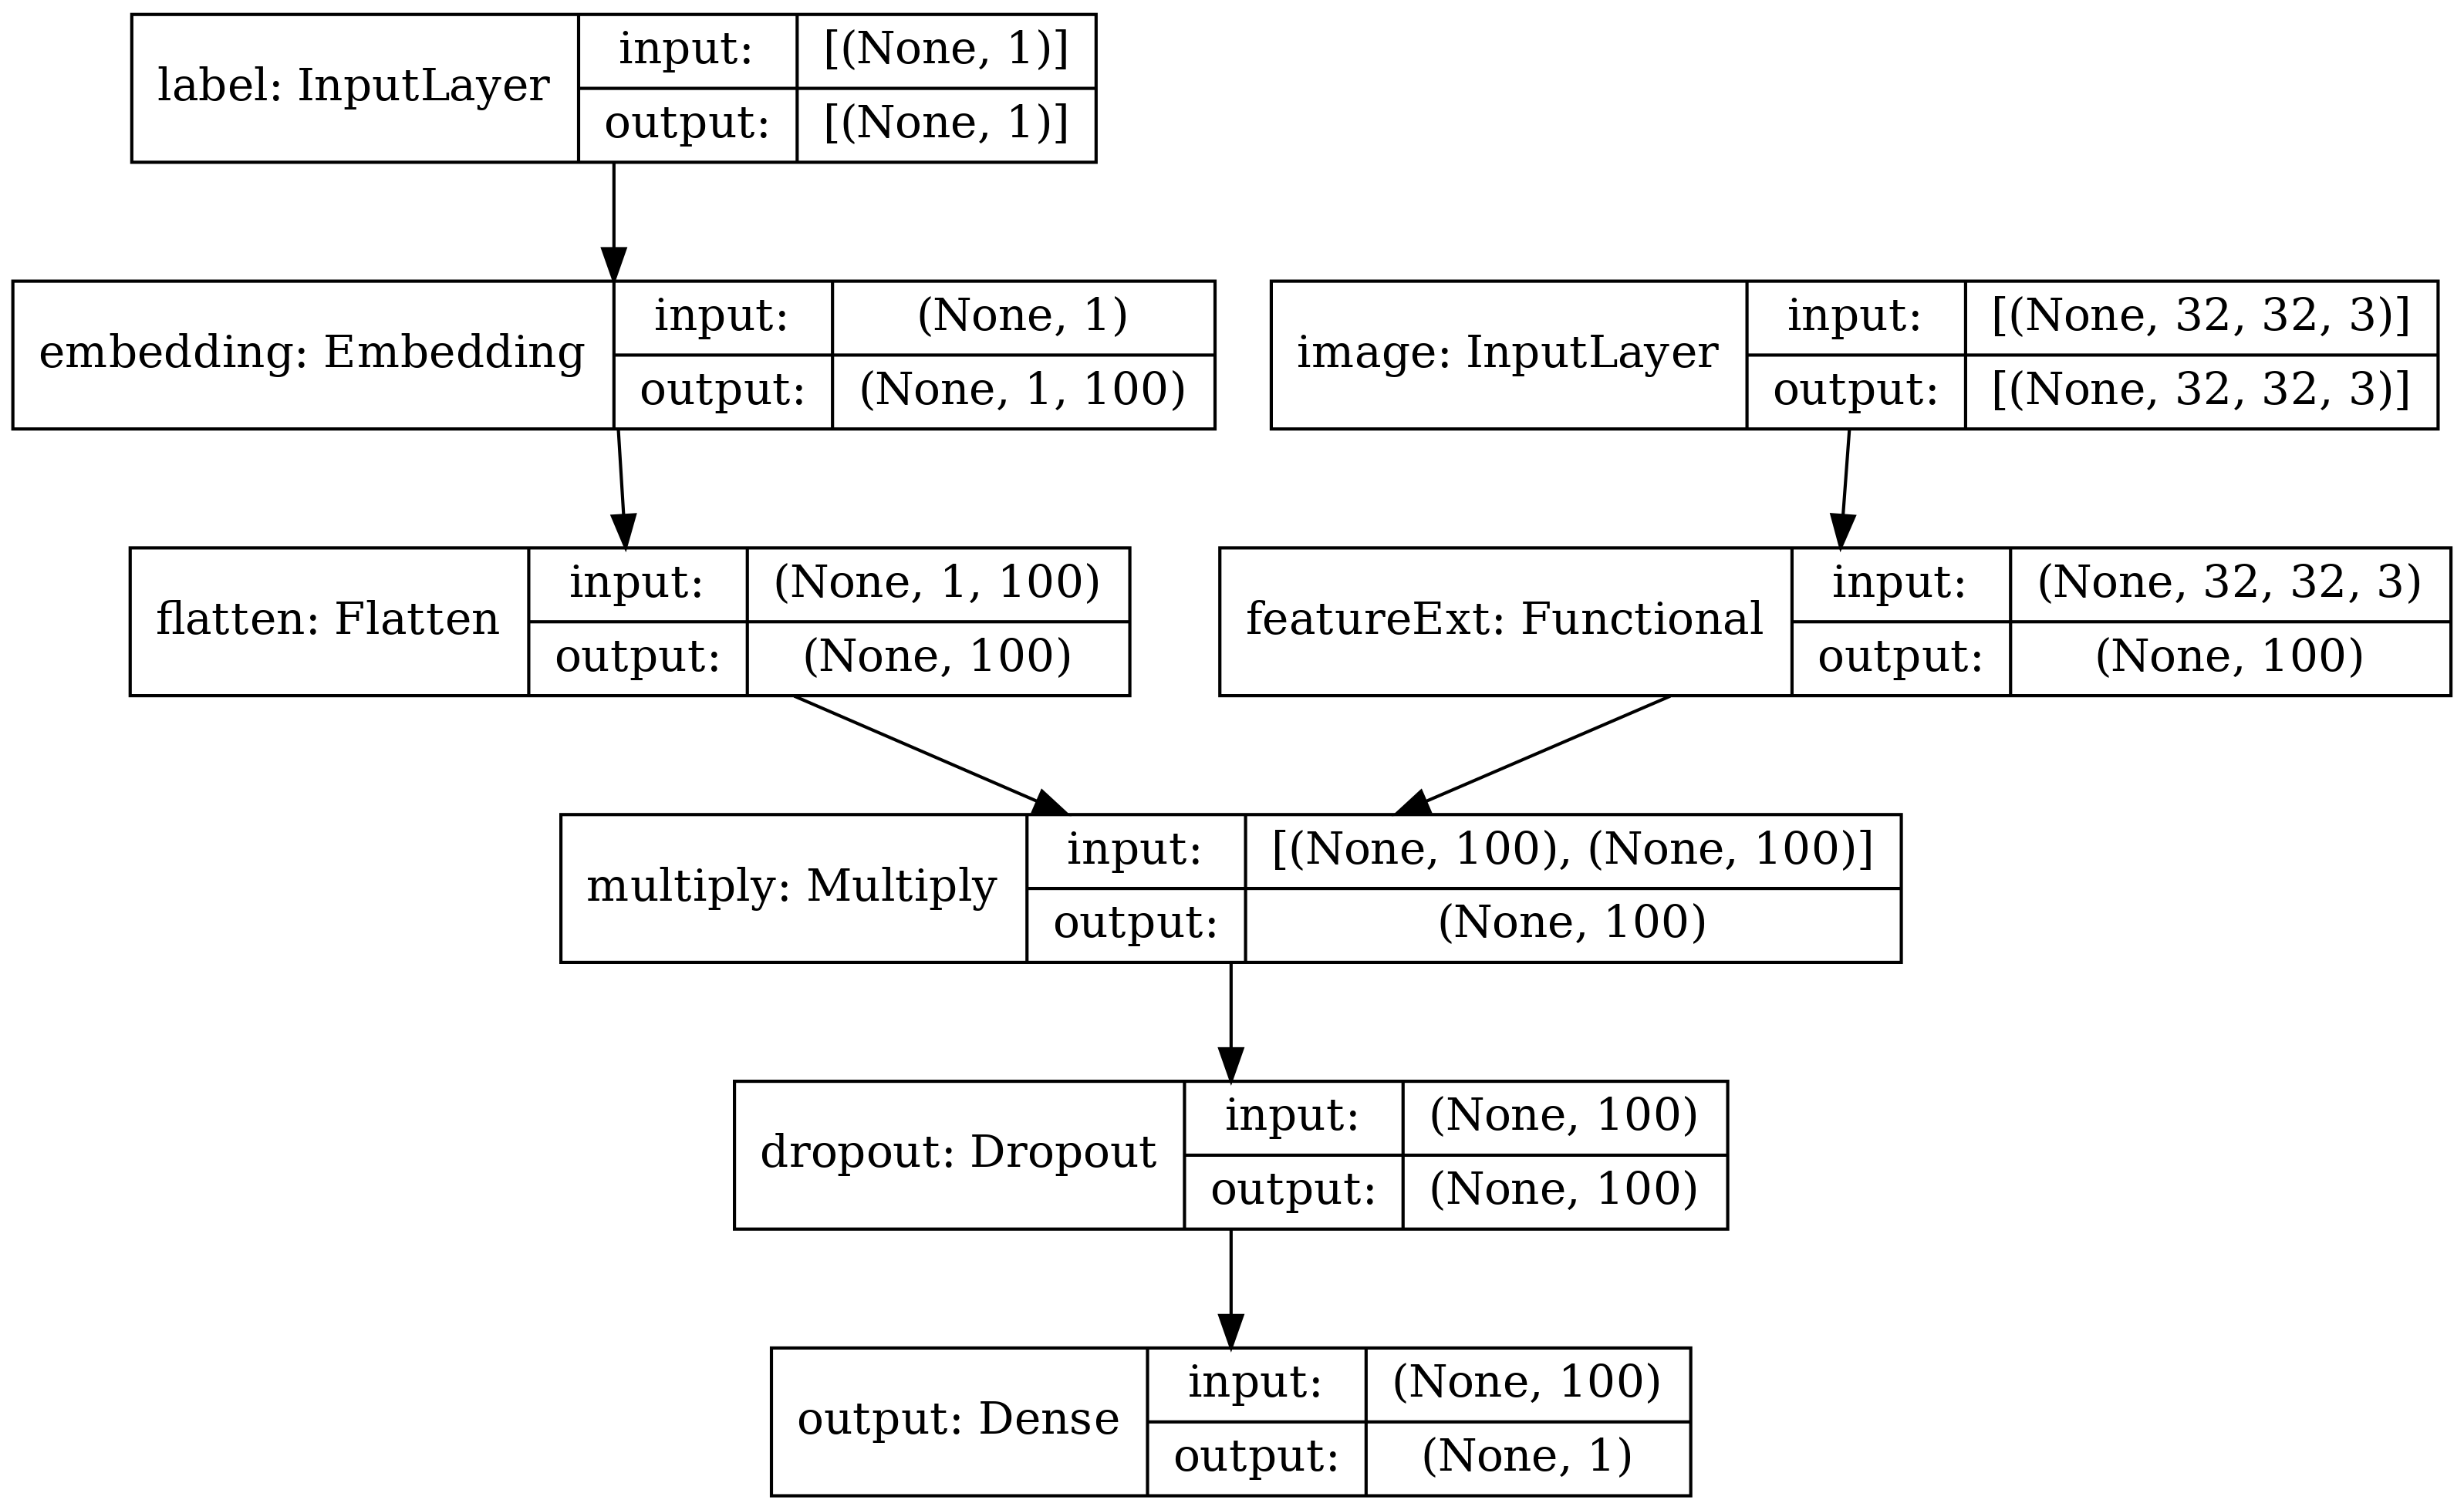

In [14]:
keras.utils.plot_model(label_conditioning_discriminator, dpi=300, show_shapes=True)